This notebook crearead in the pairs data, and creates the full low mass major pair sample that will be used as the initial dataset for this orbits project 

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

## Create data catalog 

include only low mass major pairs ~ 
note: snapshot 48 is missing in the hydro ver of TNG100

In [3]:
def pull_highmass_pairs(snapshot):
    units_dict = {
                "Group ID":"Group Number in Subfind Catalogs", 
                "Group Mass":"Physical mass from Group_M_TopHat200 -- 1e10 Msun",
                "Group Radius":"Physical radius from Group_R_TopHat200 -- kpc",
                "Group Nsubs":"Number of subhalos in group",
                "Sub1 ID":  "Subhalo ID at current snapshot",
                "Sub2 ID":  "Subhalo ID at current snapshot",
                "Sub1 Mass": "Subhalo mass at current snapshot -- 1e10 Msun",
                "Sub2 Mass": "Subhalo mass at current snapshot -- 1e10 Msun",
                "Sub1 Stellar Mass": "Stellar masses from abundance matching -- 1e10 Msun",
                "Sub2 Stellar Mass": "Stellar masses from abundance matching -- 1e10 Msun",
                "Sub1 Pos": "Subhalo physical position in box x,y,z -- kpc",
                "Sub2 Pos": "Subhalo physical position in box x,y,z -- kpc",
                "Sub1 Vel": "Subhalo velocity in vx, vy, vz -- km/s",
                "Sub2 Vel": "Subhalo velocity in vx, vy, vz -- km/s",
                "Sub1 MassType": "Mass of bound particles - gas, DM, empty, tracers, stars, BHs -- in 1e10 Msun",
                "Sub2 MassType": "Mass of bound particles - gas, DM, empty, tracers, stars, BHs -- in 1e10 Msun",
                "Separation": "Physical separation between primary and secondary in kpc",
                "Comoving Separation":"Comoving separation between primary and secondary in ckpc",
                "RelVel": "Relative velocity between primary and secondary in km/s",
                "Stellar Mass Ratio": "Stellar mass ratio of secondary over primary", # in this case- it's by primary subhalo mass
                "Realization": "Stellar mass realization (0-1000)",
                "Sub1 BHMass": "Sum of the masses of all blackholes -- 1e10 Msun",
                "Sub2 BHMass": "Sum of the masses of all blackholes -- 1e10 Msun",
                "Sub1 BHMdot": "Instantaneous accretion rates of all blackholes -- 1e10 Msun / 0.978Gyr",
                "Sub2 BHMdot": "Instantaneous accretion rates of all blackholes -- 1e10 Msun / 0.978Gyr",
                "Sub1 SFR": "Sum of the individual SFRs of all gas cells in subhalo -- Msun / yr",
                "Sub2 SFR": "Sum of the individual SFRs of all gas cells in subhalo -- Msun / yr",
                "Sub1 SFRinRad": "Sum of SFRs of all gas cells within twice the stellar half mass radius -- Msun / yr",
                "Sub2 SFRinRad": "Sum of SFRs of all gas cells within twice the stellar half mass radius -- Msun / yr",
                "Sub1 GasMetallicity": "Mz/Mtot, where Z = any element above He within 2x stellar half mass radius -- unitless",
                "Sub2 GasMetallicity": "Mz/Mtot, where Z = any element above He within 2x stellar half mass radius -- unitless",
                "TripleFlag": "0 if no tertiary with mass ratio > 1:10 of secondary, 1 if large tertiary, 2 if other problem occurred"
                }
    
    snapdata = h5py.File(f"/xdisk/gbesla/katiechambe/pears/data/pairs/TNG_{snapshot}_10.hdf5","r")
    pairs = {}
    for key, val in snapdata['pairs']['hydro'].items():
        pairs[key]=np.array(val)
    redshift = snapdata["Header"].attrs["Redshift"]
    scale = 1/(1+redshift)
    snapdata.close()

    maskk  = pairs['Realization']==-1    

    medianpairs = {}
    for key in pairs.keys():
        medianpairs[key] = pairs[key][maskk]

    # make functions to get data at the requested snapshot
    def get_primmask(primstells, size):
        if size == "low":
            mask = (primstells > 0.01) & (primstells < 0.5)
        elif size == "high":
            mask = (primstells > 0.5) & (primstells < 10)
        return mask

    def get_groupmask(groupmass, size):
        if size == "low":
            mask = (groupmass > 8) & (groupmass < 50)
        elif size == "high":
            mask = (groupmass > 100) & (groupmass < 650)
        return mask

    # get out the things that are in dwarf groups:
    group_mask = get_groupmask(medianpairs['Group Mass'],"high")
    primary_mask = get_primmask(medianpairs['Sub1 Stellar Mass'], "high")
    major_mask = (medianpairs['Sub2 Stellar Mass']/medianpairs['Sub1 Stellar Mass'] > 1/4)

    fullmask = group_mask&primary_mask&major_mask

        # make data file
    f = h5py.File(f"../../data/big-bad/highmass_{snapshot}.hdf5", 'w')
    header_dict = {"Details":f"High mass major pairs at z={redshift:.1f}",
            "Snapshot":snapshot,
            "Scale":scale,
            "Redshift":redshift,
            "Simulation":"TNG100-1"}

    dset = f.create_group('/Header')
    for key in header_dict.keys():
        dset.attrs[key] = header_dict[key]

    for key, val in medianpairs.items():
        val = np.array(val)[fullmask]
        dset = f.create_dataset(f'/{key}', 
                                shape=val.shape,
                                dtype=val.dtype)
        dset.attrs[key] = units_dict[key]
        dset[:] = val

    f.close()
    print(f"Snapshot {snapshot} - total number of all pairs, median pairs, and high mass major pairs: {len(pairs['Sub1 Stellar Mass'])}, {len(medianpairs['Sub1 Stellar Mass'])}, {len(medianpairs['Sub1 Stellar Mass'][fullmask])}")



The following cell creates and saves a data file containing info on each low mass major pair at each redshift

In [4]:
for i in [33,40,50]:
    pull_highmass_pairs(i)

Snapshot 33 - total number of all pairs, median pairs, and high mass major pairs: 201780, 16815, 158
Snapshot 40 - total number of all pairs, median pairs, and high mass major pairs: 219468, 18289, 212
Snapshot 50 - total number of all pairs, median pairs, and high mass major pairs: 219816, 18318, 276


In [5]:
for i in np.arange(0,100,1):
    if i == 48:
        continue
    pull_highmass_pairs(i)

Snapshot 0 - total number of all pairs, median pairs, and high mass major pairs: 0, 0, 0
Snapshot 1 - total number of all pairs, median pairs, and high mass major pairs: 0, 0, 0
Snapshot 2 - total number of all pairs, median pairs, and high mass major pairs: 0, 0, 0
Snapshot 3 - total number of all pairs, median pairs, and high mass major pairs: 0, 0, 0
Snapshot 4 - total number of all pairs, median pairs, and high mass major pairs: 48, 4, 0
Snapshot 5 - total number of all pairs, median pairs, and high mass major pairs: 108, 9, 0
Snapshot 6 - total number of all pairs, median pairs, and high mass major pairs: 264, 22, 0
Snapshot 7 - total number of all pairs, median pairs, and high mass major pairs: 600, 50, 0
Snapshot 8 - total number of all pairs, median pairs, and high mass major pairs: 1260, 105, 0
Snapshot 9 - total number of all pairs, median pairs, and high mass major pairs: 2220, 185, 0
Snapshot 10 - total number of all pairs, median pairs, and high mass major pairs: 3564, 297

Snapshot 85 - total number of all pairs, median pairs, and high mass major pairs: 195120, 16260, 344
Snapshot 86 - total number of all pairs, median pairs, and high mass major pairs: 194880, 16240, 343
Snapshot 87 - total number of all pairs, median pairs, and high mass major pairs: 193416, 16118, 351
Snapshot 88 - total number of all pairs, median pairs, and high mass major pairs: 193056, 16088, 358
Snapshot 89 - total number of all pairs, median pairs, and high mass major pairs: 191460, 15955, 368
Snapshot 90 - total number of all pairs, median pairs, and high mass major pairs: 190140, 15845, 369
Snapshot 91 - total number of all pairs, median pairs, and high mass major pairs: 189636, 15803, 374
Snapshot 92 - total number of all pairs, median pairs, and high mass major pairs: 188928, 15744, 360
Snapshot 93 - total number of all pairs, median pairs, and high mass major pairs: 188808, 15734, 371
Snapshot 94 - total number of all pairs, median pairs, and high mass major pairs: 187860, 1

## Calculate merger fraction vs. z

In [7]:
def calculate_mergerfrac(snapshot):
    
    f = h5py.File(f"../../data/big-bad/highmass_{snapshot}.hdf5", 'r')
    pairs = {}
    for key, val in f.items():
        if key == "Header":
            continue
        pairs[key] = np.array(val)
        
        redshift = f["Header"].attrs["Redshift"]
    f.close()
    
    if len(pairs['Sub1 ID']) == 0:
        return 0
    
    else:
        # init array
        merger_root= np.zeros(len(pairs['Sub1 ID']))

        # for each subhalo pair, check if they merge and update data arrays
        for ind in range(len(pairs['Sub1 ID'])):
            primary_id = pairs['Sub1 ID'][ind]
            secondary_id = pairs['Sub2 ID'][ind]

            treedict = {}
            for sub in [primary_id,secondary_id]:
                treedict[sub] = TraceMergerTree(snapshot=snapshot,physics="hydro",sim="TNG",subfindID=sub)

            tree_primary = treedict[primary_id].mergedbranch
            tree_secondary = treedict[secondary_id].mergedbranch

            # check if root descendant ID is the same between the two halos
            root1 = tree_primary['RootDescendantID'][0]
            root2 = tree_secondary['RootDescendantID'][0]
            check_root = root1 == root2

            if check_root:
                merger_root[ind] = True
            else: 
                merger_root[ind] = False
                
        # I think this can't happen, but just in case of div by 0
        if len(merger_root) == 0:
            return np.nan
        else:
            return np.count_nonzero(merger_root) / len(merger_root)


write snapshot and merger fraction to csv file

In [8]:
from csv import writer

for i in np.arange(0,100,1):
    if i == 48:
        continue
        
    mergfrac = calculate_mergerfrac(i)

    with open('../../data/big-bad/highmass_merger_fraction.csv', 'a') as file_obj:
        writer(file_obj).writerow([i,mergfrac])
        file_obj.close()

## Plot merger fraction

In [9]:
dat = pd.read_csv('../../data/big-bad/highmass_merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))


In [10]:
dat[40:60]

,Snapshot,Fraction
40,40,0.948113
41,41,0.949367
42,42,0.933610
43,43,0.939655
44,44,0.922131
45,45,0.916996
46,46,0.920949
47,47,0.925094
48,49,0.906716
49,50,0.916667


In [11]:
f = h5py.File(f"{paths.path_data}hail-mary/snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

In [ ]:
snap_dict['Redshift']

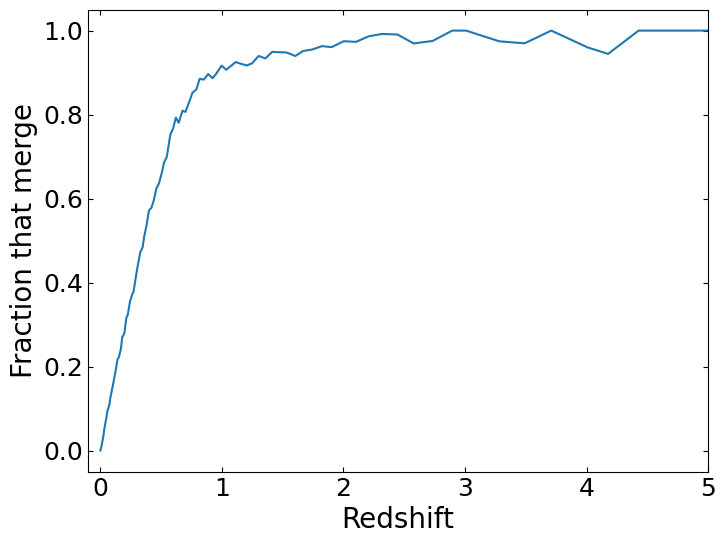

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(snap_dict['Redshift'][snap_dict['Snapshot']!=48],dat['Fraction'])
ax.set_xlim(-0.1,5)
ax.set_xlabel("Redshift")
ax.set_ylabel("Fraction that merge")
plt.show()

## Comparison of merger fracs (low v. high)

In [15]:
dat_massive = pd.read_csv('../../data/big-bad/highmass_merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))
dat_low = pd.read_csv('../../data/hail-mary/merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))


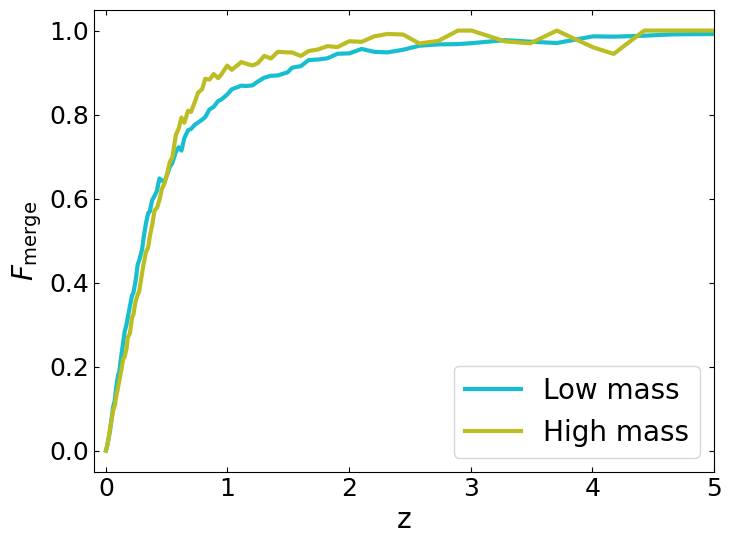

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(snap_dict['Redshift'][snap_dict['Snapshot']!=48],dat_low['Fraction'],label="Low mass",color="tab:cyan",lw=3)
ax.plot(snap_dict['Redshift'][snap_dict['Snapshot']!=48],dat_massive['Fraction'],label="High mass",color="tab:olive",lw=3)
ax.set_xlim(-0.1,5)
ax.set_xlabel(r"z")
ax.set_ylabel(r"$F_{\rm merge}$")
ax.legend()
plt.savefig("../../plots/big-bad/fmerge_comp.png")
plt.show()